# Analysis for the Modeling Game

In [1]:
%matplotlib inline
import lmfit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint

import tellurium as te
import gene_network as gn
import modeling_game as mg
import model_fitting as mf
import gene_analyzer as ga
import util

## Analysis Codes

In [2]:
def evaluate(desc_stgs, **kwargs):
    analyzer = ga.GeneAnalyzer()
    for desc_stg in desc_stgs:
        analyzer.do(desc_stg, **kwargs)
        title = "%s: Rsq = %1.2f" % (desc_stg, analyzer.rsq)
        plt.figure()
        analyzer.plot(title=title)
    return analyzer

## Explorations of Gene Structures

In [3]:
analyzers = []

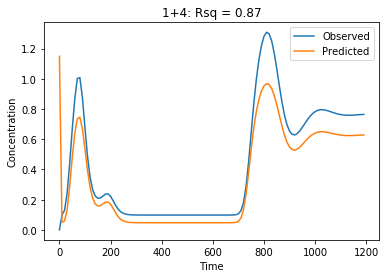

In [4]:
analyzers.append(evaluate(["1+4"], max_iteration=20, start_time=0, end_time=1200))

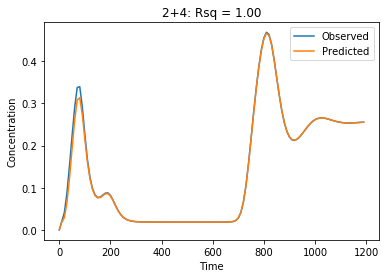

In [5]:
analyzers.append(evaluate(["2+4"], max_iteration=20, start_time=0, end_time=1200))

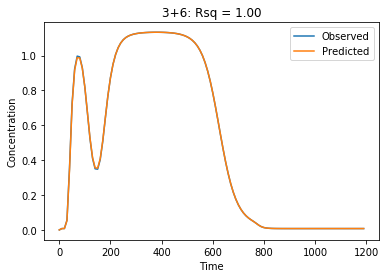

In [30]:
analyzers.append(evaluate(["3+6"], max_iteration=20, start_time=0, end_time=1200))

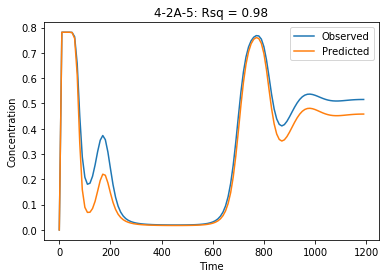

In [7]:
analyzers.append(evaluate(["4-2A-5"], max_iteration=20, start_time=0, end_time=1200))

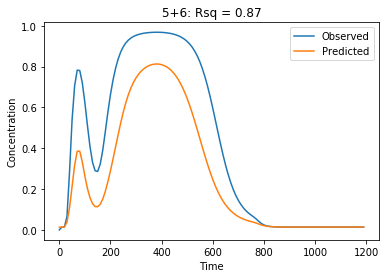

In [8]:
analyzers.append(evaluate(["5+6"], max_iteration=20, start_time=0, end_time=1200))

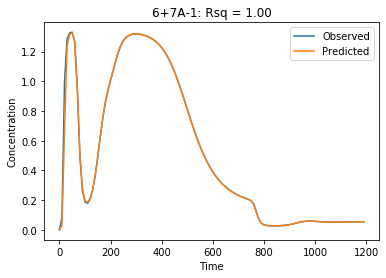

In [9]:
analyzers.append(evaluate(["6+7A-1"], max_iteration=20, start_time=0, end_time=1200))

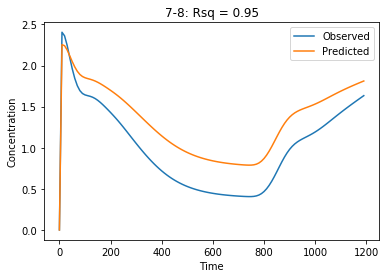

In [10]:
analyzers.append(evaluate(["7-8"], max_iteration=20, start_time=0, end_time=1200))

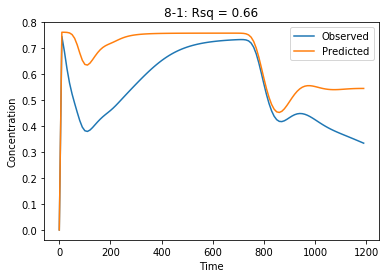

In [11]:
analyzers.append(evaluate(["8-1"], max_iteration=30, start_time=0, end_time=1200))

## Generate the New Simulation Model

In [27]:
dfs = []
for analyzer in analyzers:
    dfs.append(analyzer.makeParameterDF())
df_param = pd.concat(dfs)
df_param = df_param.set_index('name')
df_param = df_param.drop(['Vm1'])
df_param = df_param.reset_index()
df_param.to_csv("parameters.csv", index=False)

In [28]:
df_param

,name,value
0,K2_4,0.024226
1,K3_4,0.018622
2,K1_5,0.010355
3,H5,2.773300
4,Vm5,1.151615
5,K1_7,0.010299
6,H7,3.000830
7,Vm7,1.380090


In [31]:
augmented_network = ["4-2A-5", "5+6", "7-8"]
network = gn.GeneNetwork()
network.update(augmented_network)
network.generate()
print(network.model)



// Created by libAntimony v3.9.4

model *pathway()



  // Compartments and Species:

  species INPUT, P1, mRNA1, P2, mRNA2, P3, mRNA3, P4, mRNA4, P5, mRNA5, P6;

  species mRNA6, P7, mRNA7, P8, mRNA8;
J1: => mRNA1; L1 - d_mRNA1*mRNA1 + Vm1 * ( K1_1*INPUT^H1 + K2_1*P4^H1 + K3_1*INPUT^H1*P4^H1 ) / ( 1 + K1_1*INPUT^H1 + K2_1*P4^H1 + K3_1*INPUT^H1*P4^H1 )
J2: => mRNA2; L2 - d_mRNA2*mRNA2 + Vm2 * ( K1_2*P4^H2 ) / ( 1 + K1_2*P4^H2 )
J3: => mRNA3; L3 - d_mRNA3*mRNA3 + Vm3 * ( K1_3*P6^H3 ) / ( 1 + K1_3*P6^H3 )
J4: => mRNA4; L4 - d_mRNA4*mRNA4 + Vm4 * ( 1 ) / ( 1 + K1_4*P2^H4 + K2_4*P5^H4 + K3_4*P2^H4*P5^H4 )
J5: => mRNA5; L5 - d_mRNA5*mRNA5 + Vm5 * ( K1_5*P6^H5 ) / ( 1 + K1_5*P6^H5 )
J6: => mRNA6; L6 - d_mRNA6*mRNA6 + Vm6 * ( K1_6*P7^H6 ) / ( 1 + K1_6*P7^H6 + K2_6*P1^H6 + K3_6*P7^H6*P1^H6 )
J7: => mRNA7; L7 - d_mRNA7*mRNA7 + Vm7 * ( 1 ) / ( 1 + K1_7*P8^H7 )
J8: => mRNA8; L8 - d_mRNA8*mRNA8 + Vm8 * ( 1 ) / ( 1 + K1_8*P1^H8 )

  

// Protein Reactions:

  F1:  => P1; a_protein1*mRNA1 - d_prot

## Correlation Analysis
The goal here is to gain intuition about possible TF configurations for genes.

1. Construct cross correlatons between mRNA and proteins at different time lags. Plt as heatmap.

In [13]:
df_mrna = pd.read_csv("wild.csv")
df_mrna = df_mrna.set_index("time")

In [14]:
df_protein = pd.read_csv("wild_protein.csv")
df_protein = df_protein.set_index("time")

In [15]:
def correlate(df1, df2, lag=0):
    """
    Constructs the correlation with the specified lag
    for df2. Assumes that df1 and df2 have different columns.
    """
    def truncate(df, is_front=True):
        if is_front:
            df_trunc = df.loc[df.index[lag:], :]
        else:
            if lag == 0:
                df_trunc = df
            else:
                df_trunc = df.loc[df.index[:-lag], :]
        df_trunc.index = range(len(df_trunc))
        return df_trunc
    # Adjust lengths
    indices = range(len(df1) - lag)
    df1_trunc = truncate(df1, is_front=False)
    df2_trunc = truncate(df2, is_front=True)
    df_tot = pd.concat([df1_trunc, df2_trunc], axis=1)
    # Correlate and select columns
    df_corr = df_tot.corr()
    columns2 = df2.columns
    df_result = df_corr[columns2].copy()
    df_result = df_result.drop(columns2)
    return df_result

In [16]:
correlate(df_protein, df_mrna, lag=0)

,mRNA1,mRNA2,mRNA3,mRNA4,mRNA5,mRNA6,mRNA7,mRNA8
P1,0.837937,0.836838,-0.694888,0.545201,-0.698457,-0.684532,0.305153,-0.741331
P2,0.776217,0.773927,-0.675261,0.510775,-0.677081,-0.638788,0.352047,-0.770492
P3,-0.781441,-0.790280,0.915855,-0.883953,0.921819,0.705414,-0.426294,0.635281
P4,0.935956,0.945409,-0.742361,0.835263,-0.751456,-0.624192,0.394010,-0.644720
P5,-0.770369,-0.780070,0.920789,-0.880831,0.928624,0.714494,-0.421484,0.626922
P6,-0.681859,-0.689893,0.969450,-0.779082,0.981337,0.878458,-0.225525,0.497077
P7,0.103489,0.111368,0.128525,0.024111,0.112270,0.221359,0.787013,-0.623001
P8,-0.147532,-0.159306,0.170451,-0.276066,0.185288,-0.055679,-0.871868,0.713915


In [17]:
correlate(df_protein, df_mrna, lag=1)

,mRNA1,mRNA2,mRNA3,mRNA4,mRNA5,mRNA6,mRNA7,mRNA8
P1,0.776364,0.775652,-0.698129,0.487221,-0.701434,-0.688700,0.299563,-0.845637
P2,0.718747,0.716314,-0.672883,0.458818,-0.674247,-0.635470,0.346481,-0.865846
P3,-0.809547,-0.816808,0.883931,-0.903497,0.891273,0.667423,-0.496841,0.671354
P4,0.933199,0.942020,-0.721946,0.756904,-0.732284,-0.642132,0.370703,-0.786470
P5,-0.798123,-0.806300,0.890150,-0.901719,0.899058,0.675372,-0.491758,0.662265
P6,-0.698709,-0.706784,0.964504,-0.827591,0.976980,0.829024,-0.305160,0.511605
P7,0.047196,0.055741,0.172591,-0.087239,0.157352,0.222162,0.684539,-0.722674
P8,-0.137153,-0.146965,0.109333,-0.310444,0.124462,-0.142252,-0.989439,0.620850


In [18]:
correlate(df_protein, df_mrna, lag=2)

,mRNA1,mRNA2,mRNA3,mRNA4,mRNA5,mRNA6,mRNA7,mRNA8
P1,0.710269,0.709578,-0.701418,0.470916,-0.703906,-0.682630,0.351377,-0.845223
P2,0.658948,0.655994,-0.670125,0.445365,-0.670535,-0.624037,0.396060,-0.859001
P3,-0.831684,-0.838994,0.848885,-0.892804,0.857553,0.633172,-0.530934,0.725534
P4,0.912135,0.920056,-0.708571,0.712912,-0.719045,-0.661312,0.412101,-0.824403
P5,-0.820312,-0.828563,0.856220,-0.892814,0.866134,0.639795,-0.525576,0.715996
P6,-0.719820,-0.728884,0.948828,-0.849073,0.962242,0.778228,-0.341561,0.556001
P7,-0.014684,-0.007603,0.208486,-0.143757,0.195282,0.214872,0.682644,-0.676574
P8,-0.126414,-0.137529,0.042040,-0.261487,0.058260,-0.230145,-0.983930,0.644817


In [19]:
correlate(df_protein, df_mrna, lag=3)

,mRNA1,mRNA2,mRNA3,mRNA4,mRNA5,mRNA6,mRNA7,mRNA8
P1,0.643545,0.643111,-0.703088,0.462499,-0.704623,-0.650018,0.405173,-0.837310
P2,0.599545,0.596371,-0.665904,0.437922,-0.665241,-0.589118,0.446992,-0.845967
P3,-0.848684,-0.854796,0.812547,-0.873910,0.822354,0.620290,-0.565705,0.773951
P4,0.872596,0.880507,-0.703579,0.669099,-0.713157,-0.655275,0.459333,-0.853591
P5,-0.837805,-0.844878,0.820773,-0.876082,0.831507,0.625392,-0.559995,0.764047
P6,-0.746451,-0.754486,0.923610,-0.864713,0.938225,0.748989,-0.376656,0.597774
P7,-0.086897,-0.079199,0.232908,-0.198473,0.222845,0.243553,0.682917,-0.622793
P8,-0.121541,-0.131314,-0.033133,-0.208417,-0.015252,-0.264339,-0.972552,0.658716
